## M6W1 Assignment

*Q0: Have a quick overview of the features and implement a “cleaning process”. Make sure this part of the code is well organised, if possible make this an object-oriented exercise.*

In [1]:
#Import necessary dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import numpy as np
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df1 = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# check for null values in the dataset
df.isna().sum().sum()

0

In [5]:
df.nunique().sort_values()

Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PaperlessBilling       2
PhoneService           2
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
DeviceProtection       3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6531
customerID          7043
dtype: int64

In [6]:
# Based on the above, all columns are categorical except for Tenure, Monthly Charges, Total Charges
cols = ['Churn', 'gender', 'SeniorCitizen','Partner', 'Dependents', 'PaperlessBilling', 'PhoneService','Contract','StreamingMovies','StreamingTV','TechSupport','OnlineBackup','OnlineSecurity','InternetService', 'MultipleLines', 'DeviceProtection', 'PaymentMethod']
for col in cols:
    print (col,':', df[col].unique())

Churn : ['No' 'Yes']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PaperlessBilling : ['Yes' 'No']
PhoneService : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
StreamingMovies : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
OnlineSecurity : ['No' 'Yes' 'No internet service']
InternetService : ['DSL' 'Fiber optic' 'No']
MultipleLines : ['No phone service' 'No' 'Yes']
DeviceProtection : ['No' 'Yes' 'No internet service']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


The classification variables can divided into 3 groups:

1) Yes/No classification variables (Partner, dependent, ...etc) 

2) Yes/No/Other classification variables (StreamingMovies, TechSupport, ..etc)

3) Classification variables with other values (gender, contract, etc.) 


In [7]:
# we convert SeniorCitizen to Yes/No in order to plot it with the other Yes/No columns 
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'}) 

# For these columns we expect yes/no values only 
cols1 = ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']  

# For these columns we expect yes/no or a different value such as 'no internet service', or 'special package'
cols2 = ['StreamingMovies','StreamingTV','TechSupport','OnlineBackup','OnlineSecurity', 
         'MultipleLines', 'DeviceProtection']

# For these columns, we expect values other than yes/no
cols3 = ['gender','Contract','InternetService','PaymentMethod']

In [8]:
def plot_chart(cols,fz=(12,10), rot=0):
    fig, axes = plt.subplots(nrows=2, ncols=(len(cols)+1)//2, figsize=fz)
    for i, col in enumerate(cols):
        sns.countplot(x=col, data=df, ax=axes[i%2,i//2], order=df[col].value_counts().index)
        axes[i%2,i//2].set_title(col)
        axes[i%2,i//2].set_xlabel(None)
        axes[i%2,i//2].set_ylabel(None)
        xlabels = axes[i%2,i//2].get_xticklabels()
        axes[i%2,i//2].set_xticklabels(xlabels, rotation=rot)
 
    for i in range(len(cols), len(axes.flatten()) ):
        fig.delaxes(axes.flatten()[i])

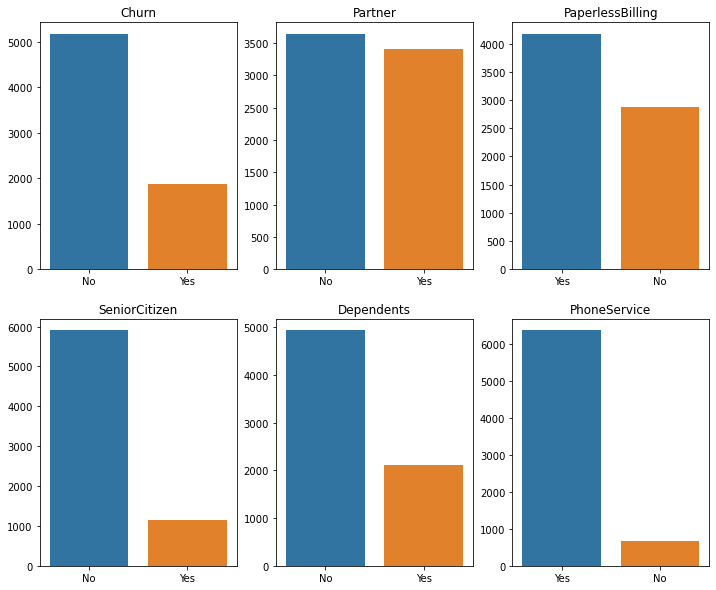

In [9]:
# Plot the first type - accept only Yes/No
plot_chart(cols1)

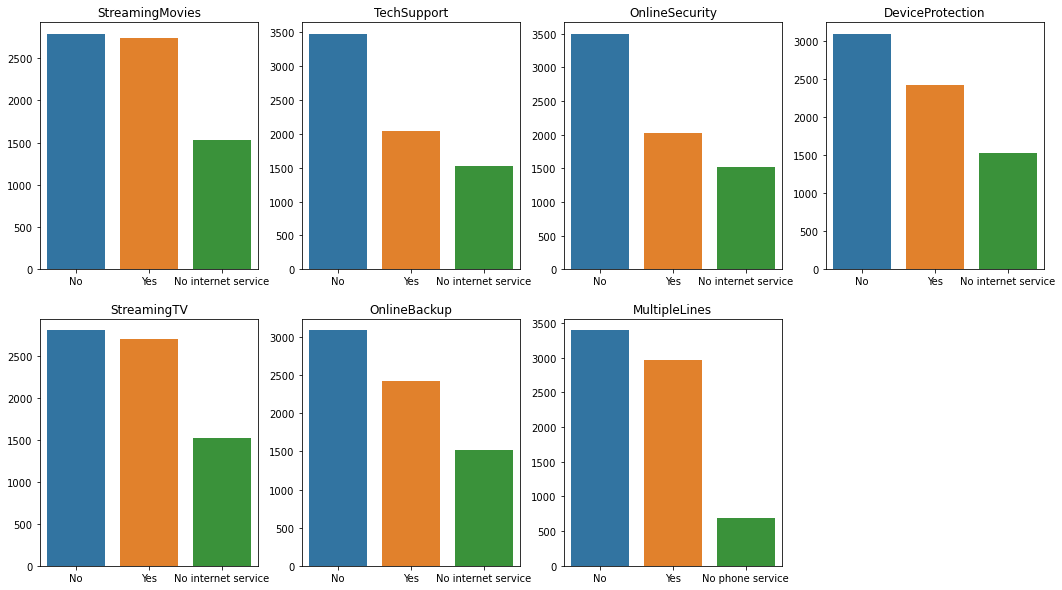

In [10]:
# plot bar charts 
plot_chart(cols2,(18,10))

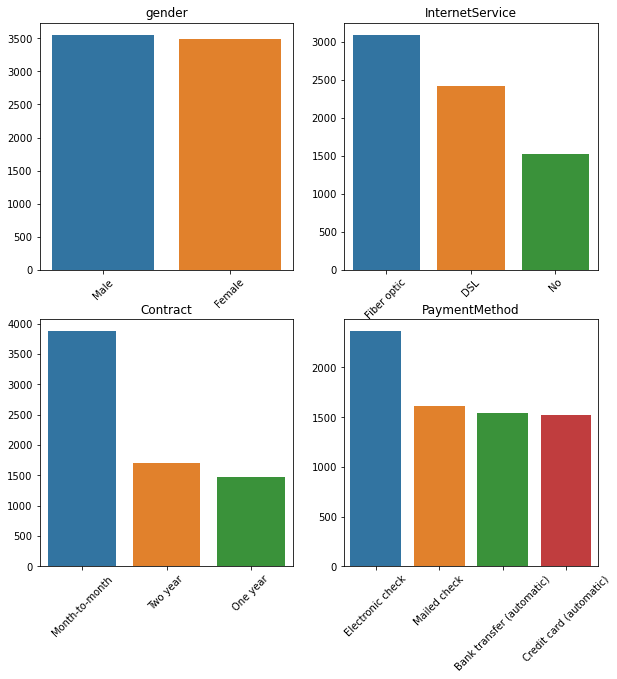

In [11]:
# plot bar charts 
plot_chart(cols3,(10,10),45)

In [12]:
# TotalCharges is showing blank when the balance is Null so will replace it to '0' then convert the column to float 
df[df['TotalCharges'] == ' '].shape

(11, 21)

In [13]:
# convert empty values to 0 and convert TotalCharges to Numeric
df['TotalCharges'] = df['TotalCharges'].str.replace (' ','0')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [14]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


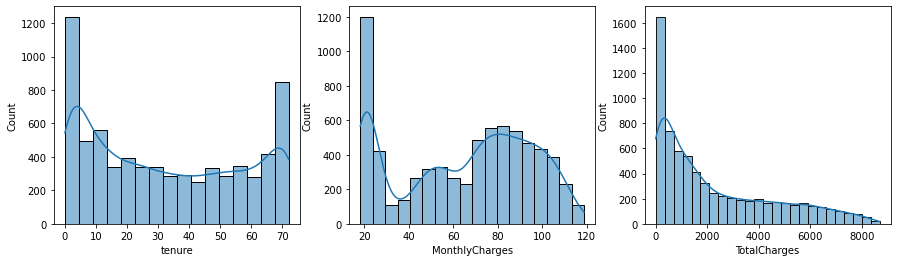

In [15]:
# now we look at the numeric values 
ncols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
for i, col in enumerate(ncols): 
    sns.histplot(df[col], kde=True, ax=axes[i])

*Q1: Explain the process that needs to happen for each feature before you train your model. Also, think about how future observations might be different from the ones you have! Be creative.*

We need to convert all the classification variables to numbers to be used in the prediction models. This can be done by assigning numerical values for each of the categorical feature we have in the dataset. 

1) Yes/No classification variables - cannot accept values other than Yes/No.

2) Yes/No/'Others' classification variables - can accept values other than Yes/No

3) Classification variables with other values (gender, contract, etc.) - can accept any value


In [16]:
#df= df1.copy()

def mapping_dict(col, yes_no=True):
    md = {}
    if (yes_no == True):
        md = {'No': 0, 'Yes': 1}
    val = col.unique()
    if len(md)==0:
        cnt=0
    else:
        cnt=max(md.values())+1
    for i in val:
        if not(i in md.keys()):
            md[i] = cnt
            cnt+=1
    return md

In [17]:
#For first group : convert category values to numbers 
for col in cols1:
    md = mapping_dict(df[col])
    df[col] = df[col].map(md)

    # for any value other than Yes/No, identify these values, flag and remove them 
    lst = [x for x in md.keys() if x not in ['Yes','No']]
    if (len(lst)>0):
        print ('The following values in',col,'cannot be accepted and needs to be revised : ', lst)
        print (df[df[col]>1].shape[0], 'rows removed from the dataset' )
        df = df[df[col]<=1]


In [18]:
# for second group : convert category values to numbers and accept any value for these columns
for col in cols2:
    md = mapping_dict(df[col])
    df[col] = df[col].map(md)

In [19]:
# We use patterns to identify males & females based on first letter - covert it to Male / Female  
print (df['gender'].value_counts())
df.loc[df['gender'].str.contains(r'^[Mm]'),'gender']='Male'
df.loc[df['gender'].str.contains(r'^[Ff]'),'gender']='Female'

# for any value other than Male/Female, itdentify these values, flag it and remove them 
lst = [x for x in list(df['gender'].unique()) if x not in ['Male','Female']]
if (len(lst)>0):
    print ('The following values in gender to be revised : ', lst)
    print (df[~df['gender'].isin(['Male','Female'])].shape[0], 'rows removed from the dataset' )
    df = df[df['gender'].isin(['Male','Female'])]

Male      3555
Female    3488
Name: gender, dtype: int64


In [20]:
# for third group : convert category values to numbers and accept any value for these columns
for col in cols3:
    md = mapping_dict(df[col], yes_no=False)
    df[col] = df[col].map(md)

df['gender'].value_counts()    

1    3555
0    3488
Name: gender, dtype: int64

In [21]:
for col in cols:
    print (col,': before -', list(df1[col].value_counts()), '&  after -', list(df[col].value_counts()))

Churn : before - [5174, 1869] &  after - [5174, 1869]
gender : before - [3555, 3488] &  after - [3555, 3488]
SeniorCitizen : before - [5901, 1142] &  after - [5901, 1142]
Partner : before - [3641, 3402] &  after - [3641, 3402]
Dependents : before - [4933, 2110] &  after - [4933, 2110]
PaperlessBilling : before - [4171, 2872] &  after - [4171, 2872]
PhoneService : before - [6361, 682] &  after - [6361, 682]
Contract : before - [3875, 1695, 1473] &  after - [3875, 1695, 1473]
StreamingMovies : before - [2785, 2732, 1526] &  after - [2785, 2732, 1526]
StreamingTV : before - [2810, 2707, 1526] &  after - [2810, 2707, 1526]
TechSupport : before - [3473, 2044, 1526] &  after - [3473, 2044, 1526]
OnlineBackup : before - [3088, 2429, 1526] &  after - [3088, 2429, 1526]
OnlineSecurity : before - [3498, 2019, 1526] &  after - [3498, 2019, 1526]
InternetService : before - [3096, 2421, 1526] &  after - [3096, 2421, 1526]
MultipleLines : before - [3390, 2971, 682] &  after - [3390, 2971, 682]
Devic

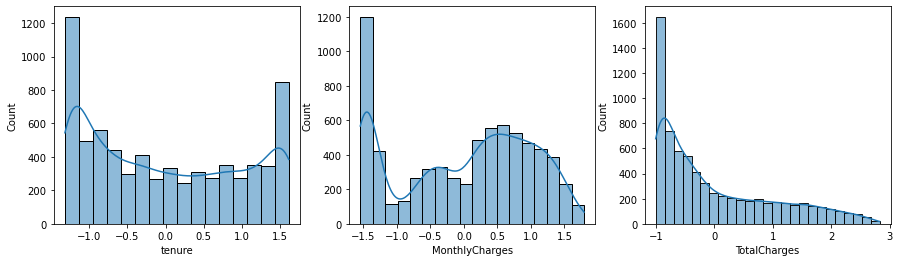

In [22]:
# Normalize Numeric Value
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
for i, col in enumerate(ncols): 
    df[col] = (df[col] - df[col].mean()) / (df[col].std())
    sns.histplot(df[col], kde=True, ax=axes[i])

In [23]:
# customerID is not required for the prediction model
df = df.drop(['customerID'],axis = 1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [25]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277354,0,2,0,0,1,0,0,0,0,0,1,0,-1.160241,-0.992540,0
1,1,0,0,0,0.066323,1,0,0,1,0,1,0,0,0,1,0,1,-0.259611,-0.172152,0
2,1,0,0,0,-1.236636,1,0,0,1,1,0,0,0,0,0,1,1,-0.362635,-0.957998,1
3,1,0,0,0,0.514215,0,2,0,1,0,1,1,0,0,1,0,2,-0.746482,-0.193659,0
4,0,0,0,0,-1.236636,1,0,1,0,0,0,0,0,0,0,1,0,0.197351,-0.938808,1


<AxesSubplot:>

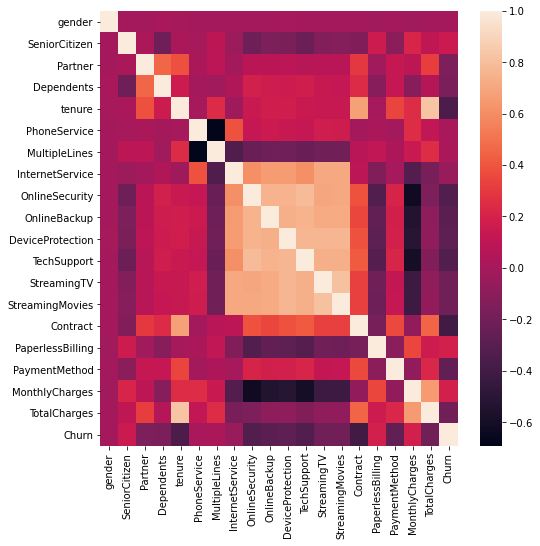

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr())

From the heatmap above, judging from the features with significant correlation coefficients of higher than 0.8, customer with internet access will normally have other online services as well such as online security, backup, tech support, streaming movies, etc.

*Q2: Choose one metric to evaluate the different models you will train and explain why you are choosing that instead of other metrics. You can try a few base models but model performance is not of prime importance yet.*

Precision measures how precise/accurate the model is out of those predicted positive, how many of them are actual positive. Precision is a good measure when the costs of False Positive is high.

While recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


In our model, the cost of not identifying the clients who will churn is the lost revenue after losing them. While the cost of flagging customers who are not planning to leave incorrectly could be calling them to check on their satisfaction level and perphaps offering them some incetives to keep their services

Assuming that the cost of losing clients is higher, we will use recall to evaluate our model. 

In [27]:
# Def X and Y
y = df['Churn']
X = df.drop('Churn', axis=1)

In [28]:
# split the dataset to train and test the model 
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print (X_train.shape)
print (X_test.shape)

(5634, 19)
(1409, 19)


#### 2. Using K Neighbors Classifier

In [29]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('k_neighbors', KNeighborsClassifier())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'k_neighbors__n_neighbors':np.arange(5,50)}

# Create the GridSearchCV object: knn
knn_cv = GridSearchCV(pipeline,param_grid=parameters,cv=5)

# Fit to the training set
knn_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % knn_cv.best_score_)
print('Best Hyperparameters: %s' % knn_cv.best_params_)

Best Score: 0.7916220778217843
Best Hyperparameters: {'k_neighbors__n_neighbors': 32}


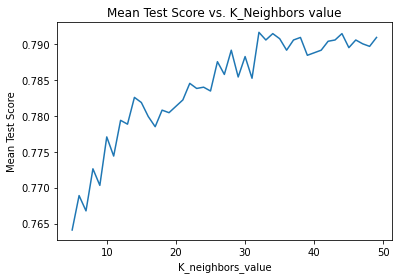

In [30]:
# Plot the mean_test_score values (after 5-fold CV) versus k_neighbors from 5 to 50 curve
x1 = np.arange(5,50)
y1 = knn_cv.cv_results_['mean_test_score']
plt.plot(x1,y1)
plt.xlabel('K_neighbors_value')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. K_Neighbors value')
plt.show()

In [31]:
# Run the model using the best paramter
#knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['k_neighbors__n_neighbors'])
knn = knn_cv.best_estimator_

# Fit to the training set
#knn.fit(X_train,y_train)

#Make the prediction:
y_pred1 = knn.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.65      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



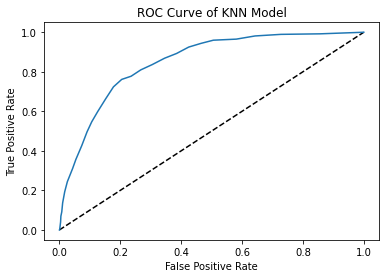

In [32]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob1 = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of KNN Model')
plt.show()

[[926 110]
 [169 204]]


Text(0.5, 1.0, 'Confusion Matrix')

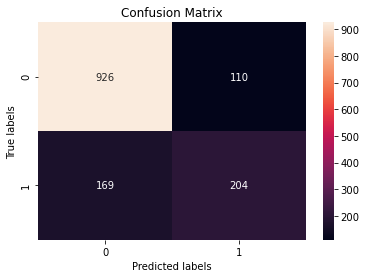

In [33]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred1)
print (cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [34]:
# since our objective is to imporve the recall ratio - we will change the threshold to see the impact 
y.value_counts()/len(y)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Text(0.5, 1.0, 'Confusion Matrix')

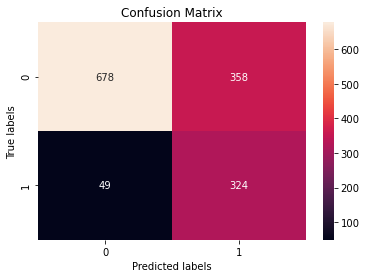

In [35]:
# assuming the threshold of 0.26
y_pred_new1 = np.where(y_pred_prob1 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new1)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [36]:
#We improved the recall ratio but the percision is lower 
print(classification_report(y_test, y_pred_new1))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1036
           1       0.48      0.87      0.61       373

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.73      1409



#### 2. Using Logistic Regression 

In [37]:
# Setup the pipeline steps: steps
steps2 = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

# Create the pipeline: pipeline 
pipeline2 = Pipeline(steps2)

# Specify the hyperparameter space
c_space = np.logspace(-5, 8, 15)
param_grid = {'logreg__C': c_space}

# Create the GridSearchCV object: knn2
logreg_cv = GridSearchCV(pipeline2,param_grid,cv=5)

# Fit to the training set
logreg_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % logreg_cv.best_score_)
print('Best Hyperparameters: %s' % logreg_cv.best_params_)

Best Score: 0.7997873919820458
Best Hyperparameters: {'logreg__C': 31.622776601683793}


In [38]:
#logreg = LogisticRegression(C=logreg_cv.best_params_['logreg__C'])
logreg = logreg_cv.best_estimator_

# Fit to the training set
#logreg.fit(X_train,y_train)

#Make the prediction:
y_pred2 = logreg.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



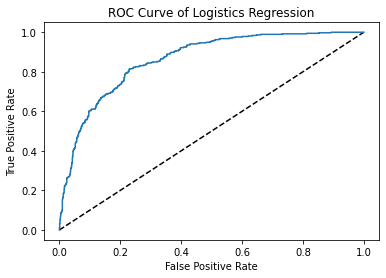

In [39]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob2 = logreg_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistics Regression')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

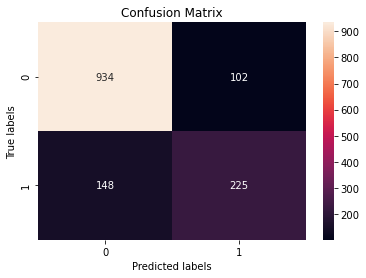

In [40]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred2)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

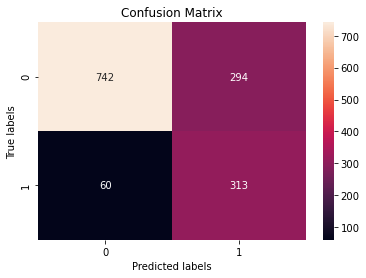

In [41]:
y_pred_new2 = np.where(y_pred_prob2 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new2)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [42]:
#We improved the recall ratio but the percision is lower 
print(classification_report(y_test, y_pred_new2))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.82      0.75      0.76      1409



## M6W2 Assignment

*Q0: Select three different models that you would like to test your dataset with. Make sure that at least two of them are tree-based models.*

*Q1: Explain why you selected these three models. You might want to discuss their peformance, explainability, complexity, etc.*

### 1. First Model : Decision Tree Classifier

Decision trees are a series of sequential steps designed to answer a question and provide probabilities, costs, or other consequence of making a particular decision. 

Decision tree is derived from the independent variables, with each node having a condition over a feature. The nodes decides which node to navigate next based on the condition. Once the leaf node is reached, an output is predicted. The right sequence of conditions makes the tree efficient. Information gain are used as the criteria to select the conditions in nodes. 

They are simple to understand, providing a clear visual to guide the decision making progress. However, this simplicity comes with a few serious disadvantages, including overfitting, error due to bias and error due to variance.  

- Overfitting happens for many reasons, including presence of noise and lack of representative instances. It's possible for overfitting with one large (deep) tree. 
- Bias error happens when you place too many restrictions on target functions. For example, restricting your result with a restricting function (e.g. a linear equation) or by a simple binary algorithm (like the true/false choices in the above tree) will often result in bias.
- Variance error refers to how much a result will change based on changes to the training set. Decision trees have high variance, which means that tiny changes in the training data have the potential to cause large changes in the final result.

**Advantages :**
- No preprocessing needed on data.
- No assumptions on distribution of data.
- Handles colinearity efficiently.
- Decision trees can provide understandable explanation over the prediction.

**Disadvantages :**
- Chances for overfitting the model if we keep on building the tree to achieve high purity. decision tree pruning can be used to solve this issue.
- Prone to outliers.
- Tree may grow to be very complex while training complicated datasets.
- Looses valuable information while handling continuous variables.

**Decision tree vs KNN :**
- Both are non-parametric methods.
- Decision tree supports automatic feature interaction, whereas KNN cant.
- Decision tree is faster due to KNN’s expensive real time execution.

**Decision Tree vs Logistic Regression :**
- Decision tree handles colinearity better than LR.
- Decision trees cannot derive the significance of features, but LR can.
- Decision trees are better for categorical values than LR.




In [43]:
# Specify the hyperparameters
param_grid = {'max_depth': range(1,10)}#, 'min_samples_leaf':[1,2,3]}

# Create the DecisionTreeClassifier : dt
dt = DecisionTreeClassifier()

# Create the GridSearchCV object: dt_cv
dt_cv = GridSearchCV(dt,param_grid,cv=5,return_train_score = True)

# Fit to the training set
dt_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % dt_cv.best_score_)
print('Best Hyperparameters: %s' % dt_cv.best_params_)

Best Score: 0.7889598282745023
Best Hyperparameters: {'max_depth': 5}


In [44]:
dt = dt_cv.best_estimator_

#Make the prediction:
y_pred3 = dt.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1036
           1       0.61      0.63      0.62       373

    accuracy                           0.80      1409
   macro avg       0.74      0.74      0.74      1409
weighted avg       0.80      0.80      0.80      1409



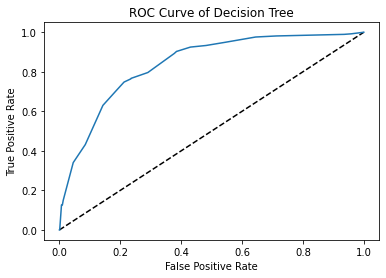

In [45]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob3 = dt_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

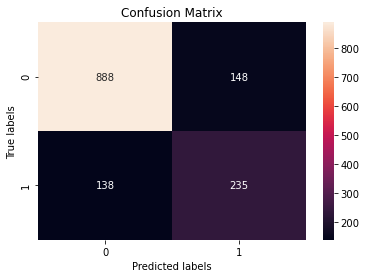

In [46]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred3)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

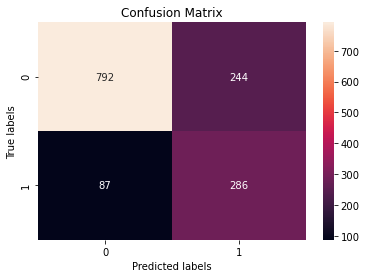

In [47]:
y_pred_new3 = np.where(y_pred_prob3 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new3)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [48]:
#We improved the recall ratio but the percision is lower 
print(classification_report(y_test, y_pred_new3))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1036
           1       0.54      0.77      0.63       373

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



In [49]:
data = pd.Series(dt.feature_importances_, index=X.columns)
print (data)

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.107113
PhoneService        0.005093
MultipleLines       0.000000
InternetService     0.076745
OnlineSecurity      0.138476
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.533744
PaperlessBilling    0.001564
PaymentMethod       0.013919
MonthlyCharges      0.064810
TotalCharges        0.058536
dtype: float64


<AxesSubplot:>

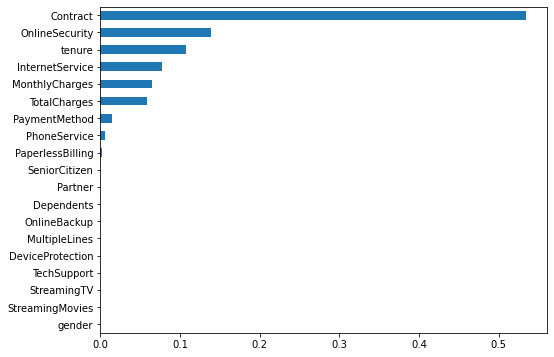

In [50]:
 data.sort_values(ascending=True).plot.barh(figsize=(8,6))

In [51]:
plot_tree

<function sklearn.tree._export.plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rotate='deprecated', rounded=False, precision=3, ax=None, fontsize=None)>

[Text(558.0, 489.24, 'X[14] <= 0.5\ngini = 0.39\nsamples = 5634\nvalue = [4138, 1496]'),
 Text(279.0, 380.52000000000004, 'X[8] <= 0.5\ngini = 0.489\nsamples = 3083\nvalue = [1768, 1315]'),
 Text(139.5, 271.8, 'X[4] <= -0.891\ngini = 0.5\nsamples = 2096\nvalue = [1024, 1072]'),
 Text(69.75, 163.08000000000004, 'X[7] <= 0.5\ngini = 0.464\nsamples = 1012\nvalue = [370, 642]'),
 Text(34.875, 54.360000000000014, '\n  (...)  \n'),
 Text(104.625, 54.360000000000014, '\n  (...)  \n'),
 Text(209.25, 163.08000000000004, 'X[7] <= 0.5\ngini = 0.479\nsamples = 1084\nvalue = [654, 430]'),
 Text(174.375, 54.360000000000014, '\n  (...)  \n'),
 Text(244.125, 54.360000000000014, '\n  (...)  \n'),
 Text(418.5, 271.8, 'X[17] <= 0.887\ngini = 0.371\nsamples = 987\nvalue = [744, 243]'),
 Text(348.75, 163.08000000000004, 'X[4] <= -1.257\ngini = 0.338\nsamples = 832\nvalue = [653, 179]'),
 Text(313.875, 54.360000000000014, '\n  (...)  \n'),
 Text(383.625, 54.360000000000014, '\n  (...)  \n'),
 Text(488.25, 1

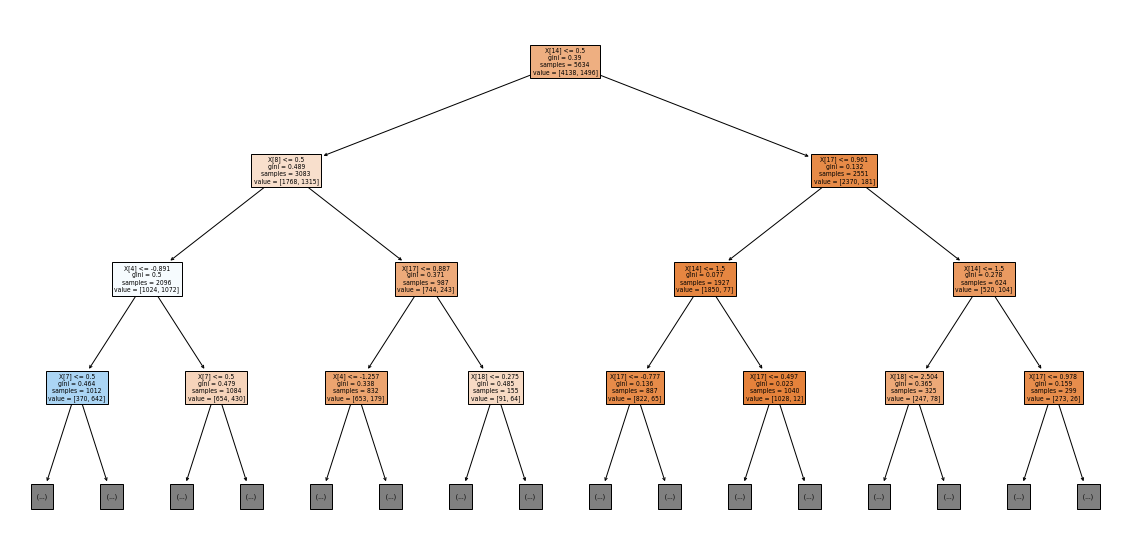

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt , filled=True, max_depth=3)

### 2. Second Model : Random Forest Classifier

Random Forest is a collection of decision trees with a single, aggregated result. It is an ensemble model that uses a set of decision trees ensembled with “bagging method” to obtain classification and regression outputs. In classification, it calculates the output using majority voting , whereas in regression, mean is calculated. The derived model will be more robust, accurate and handles overfitting better than constituent models

Random forests reduce the variance seen in decision trees by:

- Using different samples for training
- Specifying random feature subsets
- Building and combining small (shallow) trees

**Advantages :**
- Accurate and powerful model.
- handles overfitting efficiently.
- Supports implicit feature selection and derives feature importance.

**Disadvantages :**
- computationally complex and slower when forest becomes large.
- Not a well descriptive model over the prediction.

**Decision tree vs Random Forest :**
- Random Forest is a collection of decision trees and average/majority vote of the forest is selected as the predicted output.
- Random Forest model will be less prone to overfitting than Decision tree, and gives a more generalized solution.
- Random Forest is more robust and accurate than decision trees.

In [53]:
# Specify the hyperparameters
param_grid = {'max_depth': range(1,10)}#, 'min_samples_leaf':[1,2,3]}

# Create the RandomForestClassifier : rf
rf = RandomForestClassifier()

# Create the GridSearchCV object: rf_cv
rf_cv = GridSearchCV(rf,param_grid,cv=5,return_train_score = True)

# Fit to the training set
rf_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % rf_cv.best_score_)
print('Best Hyperparameters: %s' % rf_cv.best_params_)

Best Score: 0.8008516929051334
Best Hyperparameters: {'max_depth': 7}


In [54]:
rf = rf_cv.best_estimator_

#Make the prediction:
y_pred4 = rf.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



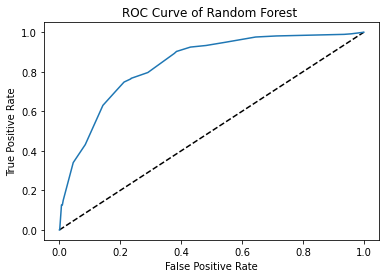

In [55]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob4 = dt_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr4, tpr4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest ')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

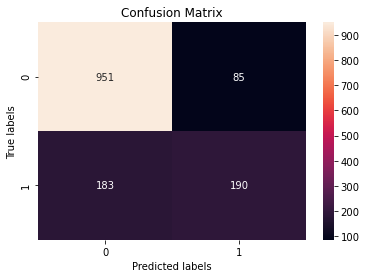

In [56]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred4)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

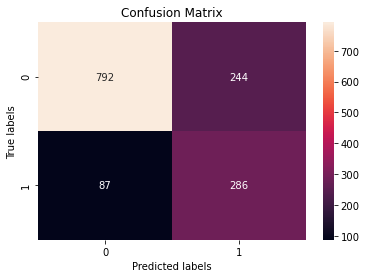

In [57]:
y_pred_new4 = np.where(y_pred_prob4 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new4)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [58]:
data = pd.Series(rf.feature_importances_, index=X.columns)
print (data)

gender              0.005839
SeniorCitizen       0.009386
Partner             0.007012
Dependents          0.006847
tenure              0.162098
PhoneService        0.003589
MultipleLines       0.010819
InternetService     0.053518
OnlineSecurity      0.109321
OnlineBackup        0.024587
DeviceProtection    0.019259
TechSupport         0.084654
StreamingTV         0.014041
StreamingMovies     0.016992
Contract            0.168250
PaperlessBilling    0.018631
PaymentMethod       0.062884
MonthlyCharges      0.093007
TotalCharges        0.129265
dtype: float64


<AxesSubplot:>

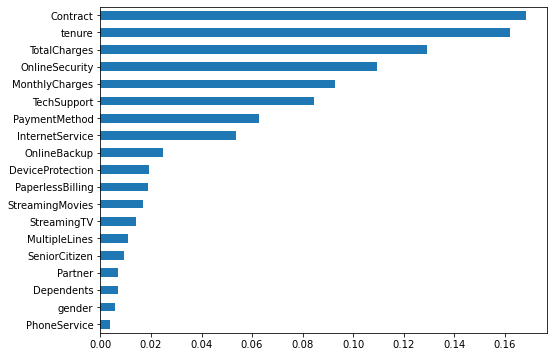

In [59]:
data.sort_values(ascending=True).plot.barh(figsize=(8,6))

### 3. Third Model : Gradient Boosting Classifier

Gradient boosting is a also a set of decision trees. The two main differences are:

- How trees are built: random forests builds each tree independently while gradient boosting builds one tree at a time. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners. 
- Combining results: random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

By carefully tune parameters, gradient boosting can result in better performance than random forests. However, gradient boosting may not be a good choice if we have a lot of noise, as it can result in overfitting. They also tend to be harder to tune than random forests.

Random forests and gradient boosting each excel in different areas. Random forests perform well for multi-class object detection and bioinformatics, which tends to have a lot of statistical noise. Gradient Boosting performs well when you have unbalanced data such as in real time risk assessment.


**Advantages :**
- Since boosted trees are derived by optimizing an objective function, basically GBM can be used to solve almost all objective function that we can write gradient out. This including things like ranking and poission regression, which RF is harder to achieve.

**Disadvatages :**
- GBMs are more sensitive to overfitting if the data is noisy.
- Training generally takes longer because of the fact that trees are built sequentially.
- GBMs are harder to tune than RF. There are typically three parameters: number of trees, depth of trees and learning rate, and each tree built is generally shallow

In [60]:
# Specify the hyperparameters
param_grid = {'max_depth': range(1,10)}#, 'min_samples_leaf':[1,2,3]}

# Create the GradientBoostingClassifier : gb
gb =  GradientBoostingClassifier()

# Create the GridSearchCV object: gb_cv
gb_cv = GridSearchCV(gb,param_grid,cv=5,return_train_score = True)

# Fit to the training set
gb_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % gb_cv.best_score_)
print('Best Hyperparameters: %s' % gb_cv.best_params_)

Best Score: 0.803869339843436
Best Hyperparameters: {'max_depth': 2}


In [61]:
gb = gb_cv.best_estimator_

#Make the prediction:
y_pred5 = gb.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



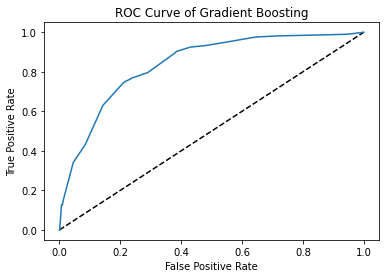

In [62]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob5 = dt_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr5, tpr5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Gradient Boosting')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

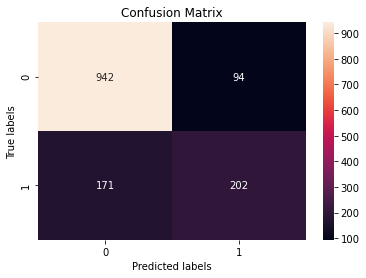

In [63]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred5)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

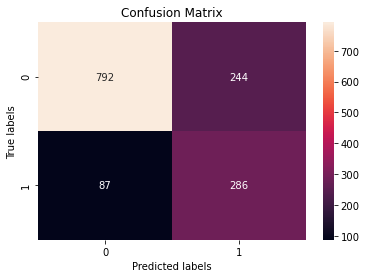

In [64]:
y_pred_new5 = np.where(y_pred_prob5 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new5)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [65]:
data = pd.Series(gb.feature_importances_, index=X.columns)
print (data)

gender              0.000000
SeniorCitizen       0.004316
Partner             0.000000
Dependents          0.000959
tenure              0.174546
PhoneService        0.000423
MultipleLines       0.009570
InternetService     0.007248
OnlineSecurity      0.100375
OnlineBackup        0.011952
DeviceProtection    0.000000
TechSupport         0.060486
StreamingTV         0.000000
StreamingMovies     0.000532
Contract            0.389116
PaperlessBilling    0.015644
PaymentMethod       0.049454
MonthlyCharges      0.136455
TotalCharges        0.038925
dtype: float64


<AxesSubplot:>

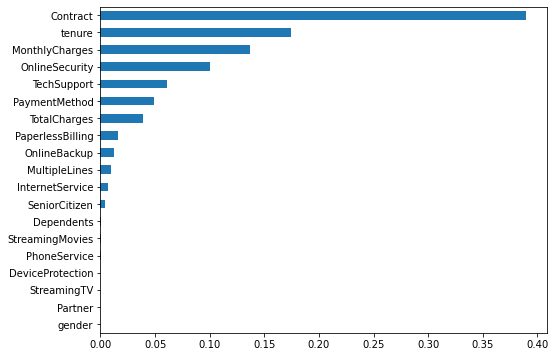

In [66]:
data.sort_values(ascending=True).plot.barh(figsize=(8,6))

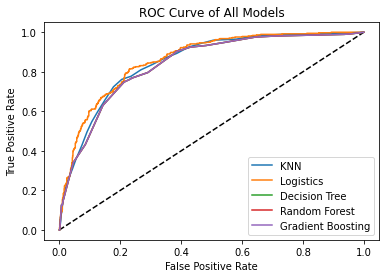

In [67]:
# Plot ROC curve to compare all models
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='KNN')
plt.plot(fpr2, tpr2, label='Logistics')
plt.plot(fpr3, tpr3, label='Decision Tree')
plt.plot(fpr4, tpr4, label='Random Forest')
plt.plot(fpr5, tpr5, label='Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of All Models')
plt.legend()
plt.show()

All models seem to perform very close to each other in terms of accuracy of the predictions when viewing from the ROC curve.

*Q3: Do you believe you have overfitting? Why?*

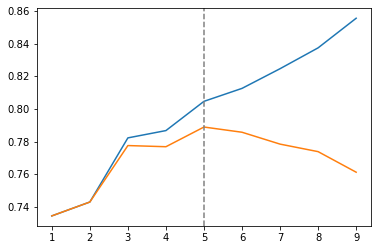

In [68]:
# overfitting
train_score = dt_cv.cv_results_["mean_train_score"]
test_score = dt_cv.cv_results_["mean_test_score"]

x = range (1,10)
plt.plot(x,train_score)
plt.plot(x,test_score)
plt.axvline(dt_cv.best_params_['max_depth'], color='gray',linestyle="--")

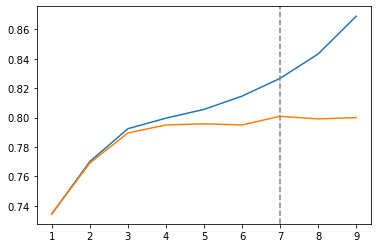

In [69]:
# overfitting
train_score = rf_cv.cv_results_["mean_train_score"]
test_score = rf_cv.cv_results_["mean_test_score"]

x = range (1,10)
plt.plot(x,train_score)
plt.plot(x,test_score)
plt.axvline(rf_cv.best_params_['max_depth'], color='gray',linestyle="--")

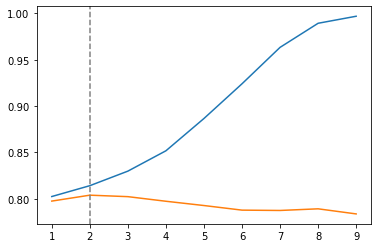

In [70]:
# overfitting
train_score = gb_cv.cv_results_["mean_train_score"]
test_score = gb_cv.cv_results_["mean_test_score"]

x = range (1,10)
plt.plot(x,train_score)
plt.plot(x,test_score)
plt.axvline(gb_cv.best_params_['max_depth'], color='gray',linestyle="--")

From the chart above, in our opinion, once the parameters used is higher than the best parameters set concluded from the GridSearchCV, each model is going to be overfitted to the training dataset - where the training accuracy increases while the accuracy of the predictions of the test dataset decreases or doesnt improve (for the two latter models). We also can observe that out of the three models: Decision Tree is the model which is most prone to the overfitting since the accuracy deteriorates quickly when the hyperparameter is tuning higher.

Now, we would like to investigate on the overview of each model performance regarding the training accuracy and testset accuracy when used the best tuned parameters by plotting the accuracy scores.

In [71]:
training_accuracy = []
testing_accuracy = []

models = {knn, logreg, dt, rf, gb}

#Compute the train and test accuracy for each model
for model in models:
    y_pred_train = model.predict(X_train).round()
    training_accuracy.append(accuracy_score(y_train, y_pred_train))
    Y_pred_test = model.predict(X_test).round()
    acc_score = accuracy_score(y_test,Y_pred_test)
    testing_accuracy.append(acc_score)

In [72]:
print(training_accuracy)
print(testing_accuracy)

[0.8244586439474618, 0.8004969826056088, 0.8022719204827831, 0.8132765353212638, 0.7980120695775648]
[0.8097941802696949, 0.7970191625266146, 0.8225691980127751, 0.8119233498935415, 0.8019872249822569]


In [73]:
df = pd.DataFrame({'models':["KNN", "Logistics Regression", "Decision Tree", "Random Forest", "Gradient Boosting"], 'TrainAccuracy':training_accuracy, 'TestAccuracy':testing_accuracy})

df.head()

,models,TrainAccuracy,TestAccuracy
0,KNN,0.824459,0.809794
1,Logistics Regression,0.800497,0.797019
2,Decision Tree,0.802272,0.822569
3,Random Forest,0.813277,0.811923
4,Gradient Boosting,0.798012,0.801987


In [74]:
df_melted = df.melt(id_vars='models')
df_melted

,models,variable,value
0,KNN,TrainAccuracy,0.824459
1,Logistics Regression,TrainAccuracy,0.800497
2,Decision Tree,TrainAccuracy,0.802272
3,Random Forest,TrainAccuracy,0.813277
4,Gradient Boosting,TrainAccuracy,0.798012
5,KNN,TestAccuracy,0.809794
6,Logistics Regression,TestAccuracy,0.797019
7,Decision Tree,TestAccuracy,0.822569
8,Random Forest,TestAccuracy,0.811923
9,Gradient Boosting,TestAccuracy,0.801987


<AxesSubplot:xlabel='variable', ylabel='value'>

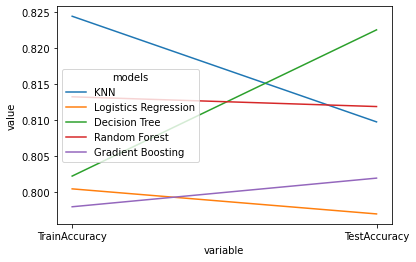

In [75]:
sns.lineplot(x='variable', y='value', hue='models', data=df_melted)

From the chart above, we can conclude that two of the selected models so far in this assignment have the overfitting issues which are the Logistics Regression and the Gradient Boosting where the test accuracy deteriorates compared to the training accuracy. The Random Forest Regressor model is quite effective in real world data where its accuracy doesnt plummet and by far the Decision Tree performs the best where the accuracy increases.